In [1]:
import sys
sys.version

'3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]'

In [2]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            print("WRONG STEP!!!")
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [5]:
class Strategy():
    def __init__(self, epsilon=0.1):
        self.Q = {}
        self.epsilon = epsilon
        pass
    
    def getAction(self, s, num_actions, pi2=None, init_zero=False):
        if s not in self.Q:
            if init_zero:
                self.Q[s] = np.zeros(num_actions)
            else:
                self.Q[s] = np.random.random(size=num_actions) * 2 - 1
        if pi2 is not None:
            if s not in pi2.Q:
                if init_zero:
                    pi2.Q[s] = np.zeros(num_actions)
                else:
                    pi2.Q[s] = np.random.random(size=num_actions) * 2 - 1
            return np.argmax(self.Q[s] + pi2.Q[s]) if np.random.rand() > self.epsilon else np.random.randint(num_actions)
        return np.argmax(self.Q[s]) if np.random.rand() > self.epsilon else np.random.randint(num_actions)

    def getActionGreedy(self, s, num_actions, pi2=None, init_zero=False):
        if s not in self.Q:
            return np.random.randint(num_actions)
        if pi2 is not None:
            if s not in pi2.Q:
                if init_zero:
                    pi2.Q[s] = np.zeros(num_actions)
                else:
                    pi2.Q[s] = np.random.random(size=num_actions) * 2 - 1
            return np.argmax(self.Q[s] + pi2.Q[s])
        return np.argmax(self.Q[s])
    
    def updateQ(self, s, a, goal, num_actions, alpha=0.1):
        if s not in self.Q:
            self.Q[s] = np.zeros(num_actions)
        self.Q[s][a] += alpha * (goal - self.Q[s][a])

In [6]:
def plot_board(env, pi, showtext=True, verbose=True):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=20, horizontalalignment='center', verticalalignment='center', color="w" )
            else:
                ax.text( a[1] , a[0] , "???", fontsize=20, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi)
    if random:
        return np.random.randint(len(actions))
    else:
        if verbose:
            if pi is not None and s in pi.Q:
                for i,a in enumerate(actions):
                    print(i, a, pi.Q[s][i])
            else:
                print("Стратегия не знает, что делать...")
        return pi.getActionGreedy(s, len(actions))
    
def get_move(env, pi, s, actions, random=False, greedy=True):
    '''Делаем ход'''
    if random:
        return np.random.randint(len(actions))
    else:
        if greedy:
            return pi.getActionGreedy(s, len(actions))
        else:
            return pi.getAction(s, len(actions))

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose)
        observation, reward, done, info = env.step(actions[a])
        if verbose:
            env.printBoard()
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False)
            
def test_games(env, pi1, pi2, n_games=100):
    crosses_count = 0
    naughts_count = 0
    for _ in range(n_games):
        done = False
        env.reset()
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                a = get_move(env, pi1, s, actions, random=pi1 is None, greedy=False)
            else:
                a = get_move(env, pi2, s, actions, random=pi2 is None, greedy=False)
            observation, reward, done, info = env.step(actions[a])
            if reward == 1:
                crosses_count += 1
            if reward == -1:
                naughts_count += 1
    print(f'X {float(crosses_count) / n_games} O {float(naughts_count) / n_games}')

### Крестики-нолики 3*3

In [199]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

Доля игр, которые выигрывают крестики и нолики при случайной игре

In [200]:
test_games(env, None, None, n_games=10000)

X 0.582 O 0.2895


Обучение стратегии крестиков

In [207]:
iterations_max = 10000000
pi1 = Strategy()
for _ in range(iterations_max):
    done = False
    env.reset()
    while not done:
        a_crosses = 0
        r_sum = 0
        num_actions = 0
        for _ in range(2):
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                a = get_move(env, None, s, actions, random=True)
                a_crosses = a
                num_actions = len(actions)
            else:
                a = get_move(env, None, s, actions, random=True)
            observation, reward, done, info = env.step(actions[a])
            r_sum += reward
            if env.curTurn == 1:
                if observation[0] in pi1.Q:
                    pi1.updateQ(s, a_crosses, r_sum + np.max(pi1.Q[observation[0]]), num_actions)
                else:
                    pi1.updateQ(s, a_crosses, r_sum, num_actions)
            if done:
                if env.curTurn != 1:
                    if observation[0] in pi1.Q:
                        pi1.updateQ(s, a_crosses, r_sum + np.max(pi1.Q[observation[0]]), num_actions)
                    else:
                        pi1.updateQ(s, a_crosses, r_sum, num_actions)
                break

Доля игр, которые выигрывают крестики и нолики при обученной стратегии для крестиков и случайной игре ноликов

In [208]:
test_games(env, pi1, None, n_games=10000)

X 0.8711 O 0.0618


Обучение стратегии ноликов

In [210]:
iterations_max = 10000000
pi2 = Strategy()
for _ in range(iterations_max):
    done = False
    env.reset()
    s, actions = env.getHash(), env.getEmptySpaces()
    a = get_move(env, None, s, actions, random=True)
    observation, reward, done, info = env.step(actions[a])
    while not done:
        a_naughts = 0
        r_sum = 0
        num_actions = 0
        for _ in range(2):
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                a = get_move(env, None, s, actions, random=True)
            else:
                a = get_move(env, None, s, actions, random=True)
                a_naughts = a
                num_actions = len(actions)
            observation, reward, done, info = env.step(actions[a])
            r_sum -= reward
            if env.curTurn != 1:
                if observation[0] in pi2.Q:
                    pi2.updateQ(s, a_naughts, r_sum + np.max(pi2.Q[observation[0]]), num_actions)
                else:
                    pi2.updateQ(s, a_naughts, r_sum, num_actions)
            if done:
                if env.curTurn == 1:
                    if observation[0] in pi2.Q:
                        pi2.updateQ(s, a_naughts, r_sum + np.max(pi2.Q[observation[0]]), num_actions)
                    else:
                        pi2.updateQ(s, a_naughts, r_sum, num_actions)
                break

Доля игр, которые выигрывают крестики и нолики при обученной стратегии для ноликов и случайной игре крестиков

In [211]:
test_games(env, None, pi2, n_games=10000)

X 0.4154 O 0.4975


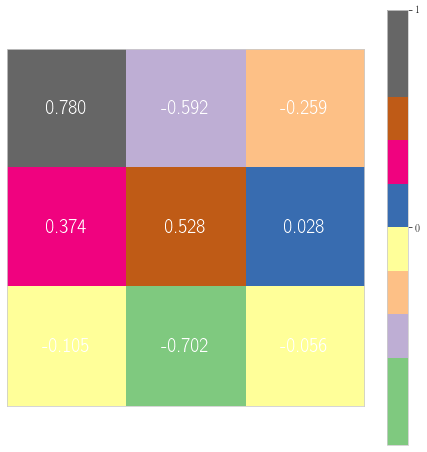

0 [0 0] 0.780307663341804
1 [0 1] -0.5918312008673519
2 [0 2] -0.2592988837575152
3 [1 0] 0.37402653164579713
4 [1 1] 0.5284407991491451
5 [1 2] 0.02820713693579724
6 [2 0] -0.10549040192002734
7 [2 1] -0.7023515251173011
8 [2 2] -0.05551456909704178
-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------


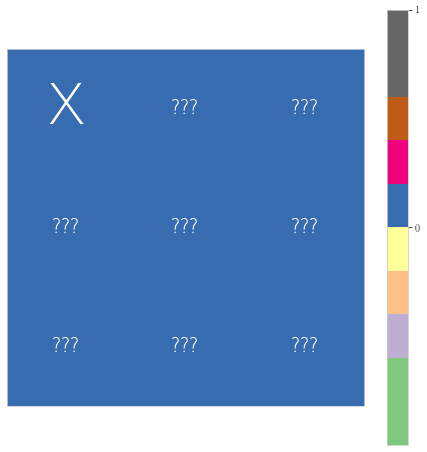

-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   | o | 
-------------


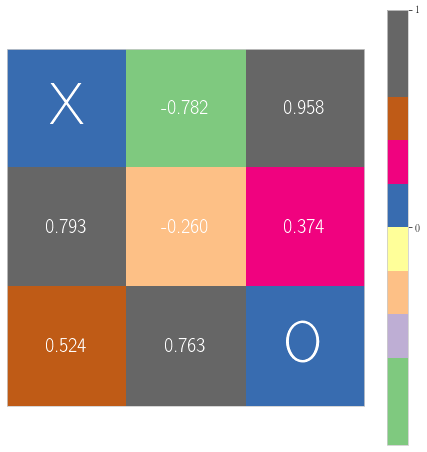

0 [0 1] -0.781651268113585
1 [0 2] 0.9580053979764187
2 [1 0] 0.7926424644423518
3 [1 1] -0.2603788497251953
4 [1 2] 0.3744141888128052
5 [2 0] 0.5244966401074551
6 [2 1] 0.7626510465980381
-------------
| x |   | x | 
-------------
|   |   |   | 
-------------
|   |   | o | 
-------------


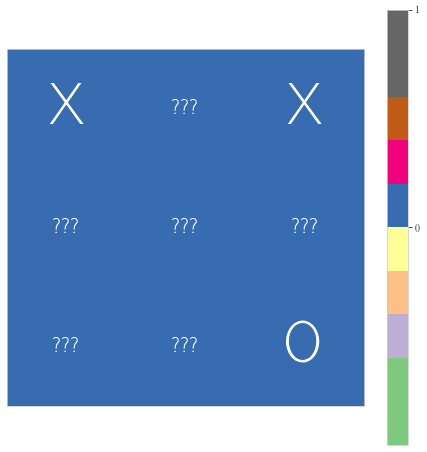

-------------
| x |   | x | 
-------------
|   |   |   | 
-------------
| o |   | o | 
-------------


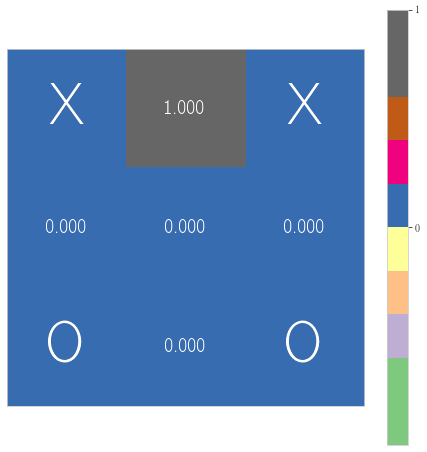

0 [0 1] 0.9999999999999996
1 [1 0] 0.0
2 [1 1] 0.0
3 [1 2] 0.0
4 [2 1] 0.0
-------------
| x | x | x | 
-------------
|   |   |   | 
-------------
| o |   | o | 
-------------
Крестики выиграли!


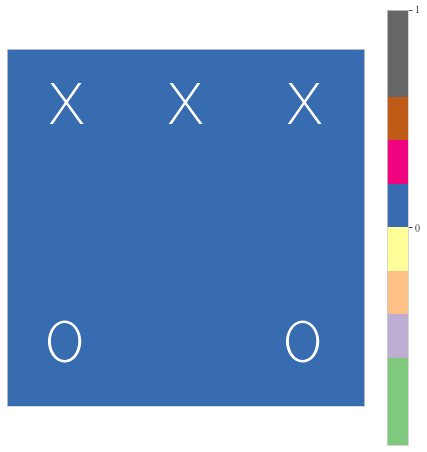

In [212]:
plot_test_game(env, pi1, None, random_crosses=False, random_naughts=True)

### Крестики-нолики 4*4

In [213]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)

Доля игр, которые выигрывают крестики и нолики при случайной игре

In [214]:
test_games(env, None, None, n_games=10000)

X 0.5833 O 0.4151


Обучение стратегии крестиков

In [215]:
iterations_max = 10000000
pi1 = Strategy()
for _ in range(iterations_max):
    done = False
    env.reset()
    while not done:
        a_crosses = 0
        r_sum = 0
        num_actions = 0
        for _ in range(2):
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                a = get_move(env, None, s, actions, random=True)
                a_crosses = a
                num_actions = len(actions)
            else:
                a = get_move(env, None, s, actions, random=True)
            observation, reward, done, info = env.step(actions[a])
            r_sum += reward
            if env.curTurn == 1:
                if observation[0] in pi1.Q:
                    pi1.updateQ(s, a_crosses, r_sum + np.max(pi1.Q[observation[0]]), num_actions)
                else:
                    pi1.updateQ(s, a_crosses, r_sum, num_actions)
            if done:
                if env.curTurn != 1:
                    if observation[0] in pi1.Q:
                        pi1.updateQ(s, a_crosses, r_sum + np.max(pi1.Q[observation[0]]), num_actions)
                    else:
                        pi1.updateQ(s, a_crosses, r_sum, num_actions)
                break

Доля игр, которые выигрывают крестики и нолики при обученной стратегии для крестиков и случайной игре ноликов

In [216]:
test_games(env, pi1, None, n_games=10000)

X 0.9344 O 0.0656


Обучение стратегии ноликов

In [217]:
iterations_max = 10000000
pi2 = Strategy()
for _ in range(iterations_max):
    done = False
    env.reset()
    s, actions = env.getHash(), env.getEmptySpaces()
    a = get_move(env, None, s, actions, random=True)
    observation, reward, done, info = env.step(actions[a])
    while not done:
        a_naughts = 0
        r_sum = 0
        num_actions = 0
        for _ in range(2):
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                a = get_move(env, None, s, actions, random=True)
            else:
                a = get_move(env, None, s, actions, random=True)
                a_naughts = a
                num_actions = len(actions)
            observation, reward, done, info = env.step(actions[a])
            r_sum -= reward
            if env.curTurn != 1:
                if observation[0] in pi2.Q:
                    pi2.updateQ(s, a_naughts, r_sum + np.max(pi2.Q[observation[0]]), num_actions)
                else:
                    pi2.updateQ(s, a_naughts, r_sum, num_actions)
            if done:
                if env.curTurn == 1:
                    if observation[0] in pi2.Q:
                        pi2.updateQ(s, a_naughts, r_sum + np.max(pi2.Q[observation[0]]), num_actions)
                    else:
                        pi2.updateQ(s, a_naughts, r_sum, num_actions)
                break

Доля игр, которые выигрывают крестики и нолики при обученной стратегии для ноликов и случайной игре крестиков

In [218]:
test_games(env, None, pi2, n_games=10000)

X 0.2197 O 0.7801


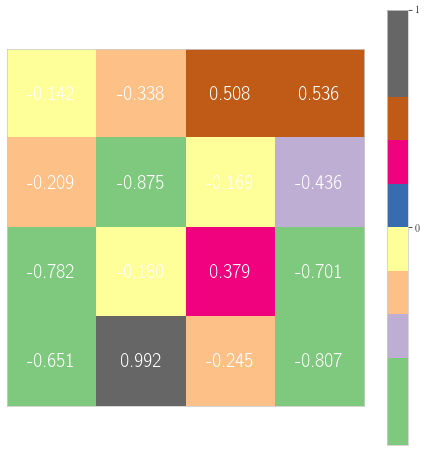

0 [0 0] -0.14156054361801917
1 [0 1] -0.33772547606462
2 [0 2] 0.5084203601780091
3 [0 3] 0.5355192669352802
4 [1 0] -0.20888159380456384
5 [1 1] -0.8746083704847929
6 [1 2] -0.16938149923231527
7 [1 3] -0.4364408150608068
8 [2 0] -0.7817351837659483
9 [2 1] -0.18036453146567388
10 [2 2] 0.37921886091609425
11 [2 3] -0.7010615898360135
12 [3 0] -0.651345542401992
13 [3 1] 0.991614083228614
14 [3 2] -0.24472688649365804
15 [3 3] -0.8074018971468448
-----------------
|   |   |   |   | 
-----------------
|   |   |   |   | 
-----------------
|   |   |   |   | 
-----------------
|   | x |   |   | 
-----------------


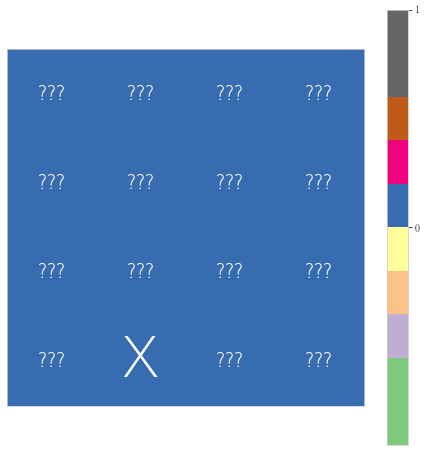

-----------------
|   |   | o |   | 
-----------------
|   |   |   |   | 
-----------------
|   |   |   |   | 
-----------------
|   | x |   |   | 
-----------------


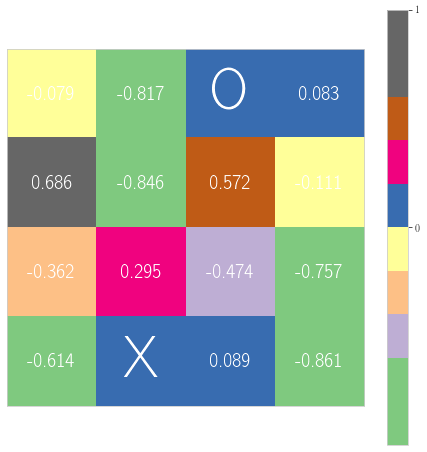

0 [0 0] -0.07920377610731433
1 [0 1] -0.8171905341226722
2 [0 3] 0.08259434490509898
3 [1 0] 0.6860831246089314
4 [1 1] -0.8464114354449477
5 [1 2] 0.5718466723006754
6 [1 3] -0.11079935316453393
7 [2 0] -0.3624576443959846
8 [2 1] 0.2951173087630161
9 [2 2] -0.47380388195775347
10 [2 3] -0.7570602166868947
11 [3 0] -0.6136295773582157
12 [3 2] 0.08924151851310258
13 [3 3] -0.8613818922804235
-----------------
|   |   | o |   | 
-----------------
| x |   |   |   | 
-----------------
|   |   |   |   | 
-----------------
|   | x |   |   | 
-----------------


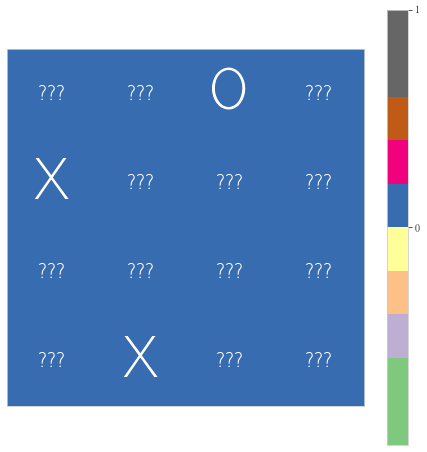

-----------------
|   |   | o |   | 
-----------------
| x |   |   |   | 
-----------------
|   |   |   |   | 
-----------------
| o | x |   |   | 
-----------------


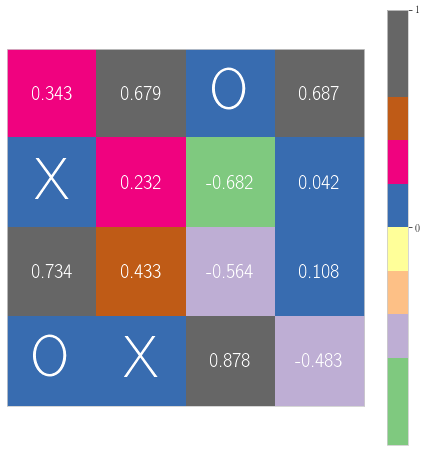

0 [0 0] 0.34331458948591287
1 [0 1] 0.6794419247422192
2 [0 3] 0.687301693658624
3 [1 1] 0.23240781257066612
4 [1 2] -0.6823205656088573
5 [1 3] 0.041558051662735185
6 [2 0] 0.7339198985755795
7 [2 1] 0.4332546029504045
8 [2 2] -0.5642679686248335
9 [2 3] 0.10793454252187629
10 [3 2] 0.878211027761834
11 [3 3] -0.48312652217459884
-----------------
|   |   | o |   | 
-----------------
| x |   |   |   | 
-----------------
|   |   |   |   | 
-----------------
| o | x | x |   | 
-----------------


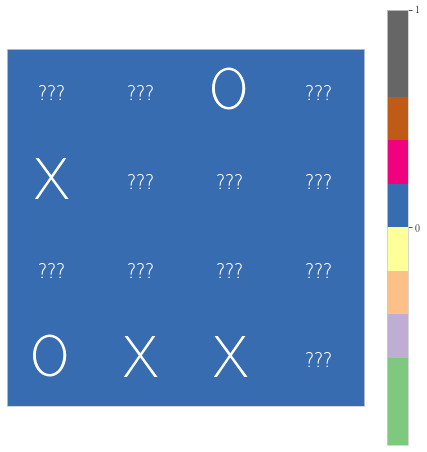

-----------------
|   |   | o |   | 
-----------------
| x |   |   |   | 
-----------------
|   |   | o |   | 
-----------------
| o | x | x |   | 
-----------------


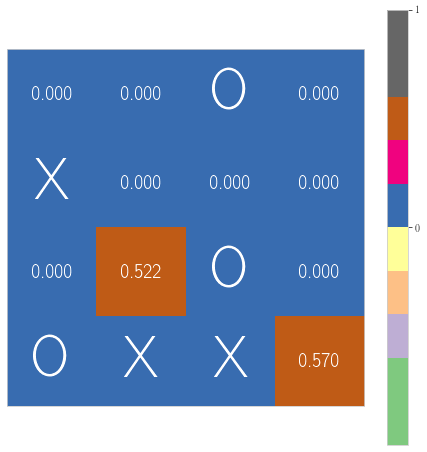

0 [0 0] 0.0
1 [0 1] 0.0
2 [0 3] 0.0
3 [1 1] 0.0
4 [1 2] 0.0
5 [1 3] 0.0
6 [2 0] 0.0
7 [2 1] 0.5217031000000001
8 [2 3] 0.0
9 [3 3] 0.5695327900000001
-----------------
|   |   | o |   | 
-----------------
| x |   |   |   | 
-----------------
|   |   | o |   | 
-----------------
| o | x | x | x | 
-----------------
Крестики выиграли!


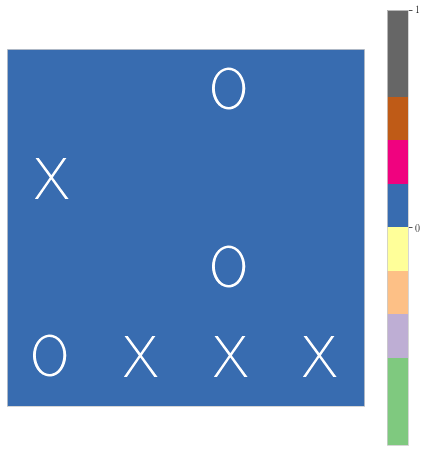

In [219]:
plot_test_game(env, pi1, None, random_crosses=False, random_naughts=True)

### Крестики-нолики 5*5

In [8]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)

Доля игр, которые выигрывают крестики и нолики при случайной игре

In [21]:
test_games(env, None, None, n_games=10000)

X 0.5361 O 0.3986


Обучение стратегии крестиков

In [14]:
iterations_max = 5000000
pi1 = Strategy()
for _ in range(iterations_max):
    done = False
    env.reset()
    while not done:
        a_crosses = 0
        r_sum = 0
        num_actions = 0
        for _ in range(2):
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                a = get_move(env, None, s, actions, random=True)
                a_crosses = a
                num_actions = len(actions)
            else:
                a = get_move(env, None, s, actions, random=True)
            observation, reward, done, info = env.step(actions[a])
            r_sum += reward
            if env.curTurn == 1:
                if observation[0] in pi1.Q:
                    pi1.updateQ(s, a_crosses, r_sum + np.max(pi1.Q[observation[0]]), num_actions)
                else:
                    pi1.updateQ(s, a_crosses, r_sum, num_actions)
            if done:
                if env.curTurn != 1:
                    if observation[0] in pi1.Q:
                        pi1.updateQ(s, a_crosses, r_sum + np.max(pi1.Q[observation[0]]), num_actions)
                    else:
                        pi1.updateQ(s, a_crosses, r_sum, num_actions)
                break

Доля игр, которые выигрывают крестики и нолики при обученной стратегии для крестиков и случайной игре ноликов

In [18]:
test_games(env, pi1, None, n_games=10000)

X 0.4967 O 0.4353


Здесь не получается выполнить столько же итераций обучения, как выше, так как возможных состояний значительно больше, в итоге это приводит к dead kernel, а данного числа итераций не хватает для улучшения результата

### DQN

In [7]:
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [77]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, n_cols, n_rows, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.Conv2d(256, action_size, 3, stride=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        return self.model(state)

In [8]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, n_cols, n_rows, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1, padding=1),
            nn.ConvTranspose2d(64, 1, 1, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        return self.model(state)

In [9]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 16         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.array([e.state for e in experiences])).float().unsqueeze(0).to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences])).float().unsqueeze(0).to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [106]:
class DQN():
    """Interacts with and learns from the environment."""

    def __init__(self, n_cols, n_rows, action_size, seed):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(n_cols, n_rows, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(n_cols, n_rows, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, env, eps=0.):
        if state is None:
            empty_spaces = env.getEmptySpaces()
            idx = random.choice(np.arange(len(empty_spaces)))
            action = empty_spaces[idx]
            return action, idx
        #state = [int(e) for e in state[0]]
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        action_values = action_values.view(action_values.size(0), -1)

        empty_spaces = env.getEmptySpaces()
        if random.random() > eps:
            action_values = action_values.cpu().data.numpy()
            #action_values_filtered = [action_values[action[0] * n_cols + action[1]][0] for action in empty_spaces]
            action_values_filtered = [action_values[0][action[0] * n_cols + action[1]] for action in empty_spaces]
            return empty_spaces[np.argmax(action_values_filtered)], np.argmax(action_values_filtered)
        else:
            idx = random.choice(np.arange(len(empty_spaces)))
            action = empty_spaces[idx]
            return action, idx

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences
        states = states.transpose(0, 1)
        next_states = next_states.transpose(0, 1)

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        #q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets_next = self.qnetwork_target(next_states).detach().permute(0,2,3,1).squeeze(-1).reshape(16, -1).max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        #q_targets = rewards + gamma * q_targets_next.squeeze(-1).squeeze(-1) * (1 - dones)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        #q_expected = self.qnetwork_local(states).squeeze(-1).squeeze(-1).gather(1, actions)
        q_expected = self.qnetwork_local(states).permute(0,2,3,1).squeeze(-1).reshape(16, -1).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [162]:
def evaluate_policy(agent, episodes=5, eps=1.0, n_rows=10, n_cols=10, n_win=5):
    env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
    returns = []
    for e in range(episodes):
        done = False
        state = env.reset()
        if state is None:
            state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
        total_reward = 0.
        action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
        state, reward, done, _ = env.step(action)
        state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
        other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
        state, reward, done, _ = env.step(other_action)
        state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
        total_reward += reward
        
        
        while not done:
            action, _ = agent.act(state, env, eps)
            state, reward, done, _= env.step(action)
            if not done:
                other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
                state, reward, done, _ = env.step(other_action)
            state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
            total_reward += reward
        returns.append(total_reward)
    return returns

### Обучение крестиков при рандомной стратегии ноликов

In [163]:
n_rows = 10
n_cols = 10
n_win = 5
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
dqn = DQN(n_rows=n_rows, n_cols=n_cols, action_size=n_rows * n_cols, seed=0)
n_episodes=1000
max_t=1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    if state is None:
        state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
    action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(other_action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    for t in range(max_t):
        action, _ = dqn.act(state, env, eps)
        next_state, reward, done, _ = env.step(action)
        if not done:
            other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
            next_state, reward, done, _ = env.step(other_action)
        next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
        dqn.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break 
    state = env.reset()
    if state is None:
        state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
    score = 0
    action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(other_action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    for t in range(max_t):
        action, _ = dqn.act(state, env, eps)
        next_state, reward, done, _ = env.step(action)
        if not done:
            other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
            next_state, reward, done, _ = env.step(other_action)
        next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if i_episode % 100 == 0:
        rewards = evaluate_policy(dqn, episodes=100, eps=eps, n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        print(f"Step: {i_episode+1}, Reward mean: {np.mean(rewards)}, Reward std: {np.std(rewards)}")
        #dqn.save()
        #if np.mean(rewards) > 0.99:
        #    break
    eps = max(eps_end, eps_decay*eps) # decrease epsilon

/tmp/ipykernel_2327/23153129.py:82: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_expected, q_targets)


Episode 100	Average Score: 0.08
Step: 101, Reward mean: 0.38, Reward std: 0.924986486387774
Episode 200	Average Score: 0.48
Step: 201, Reward mean: 0.5, Reward std: 0.8660254037844386
Episode 300	Average Score: 0.66
Step: 301, Reward mean: 0.78, Reward std: 0.6257795138864807
Episode 400	Average Score: 0.58
Step: 401, Reward mean: 0.92, Reward std: 0.3919183588453085
Episode 500	Average Score: 0.90
Step: 501, Reward mean: 0.86, Reward std: 0.5102940328869229
Episode 600	Average Score: 0.90
Step: 601, Reward mean: 0.96, Reward std: 0.27999999999999997
Episode 700	Average Score: 0.86
Step: 701, Reward mean: 0.98, Reward std: 0.19899748742132398
Episode 800	Average Score: 1.00
Step: 801, Reward mean: 0.98, Reward std: 0.19899748742132398
Episode 900	Average Score: 0.84
Step: 901, Reward mean: 0.96, Reward std: 0.27999999999999997
Episode 1000	Average Score: 0.96
Step: 1001, Reward mean: 0.96, Reward std: 0.27999999999999997


In [164]:
class DQNStrategy():
    def __init__(self, dqn):
        self.dqn = dqn
        pass
    
    def getAction(self, s, num_actions, env, pi2=None, init_zero=False):
        if s is None:
            state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
            return np.random.randint(num_actions)
        state = np.array([int(e) for e in s]).reshape(n_cols, n_rows)
        _, idx = self.dqn.act(state, env)
        return idx

In [165]:
def get_move(env, pi, s, actions, random=False):
    '''Делаем ход'''
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getAction(s, len(actions), env)

def test_games(env, pi1, pi2, n_games=100):
    crosses_count = 0
    naughts_count = 0
    for _ in range(n_games):
        done = False
        s = env.reset()
        actions = env.getEmptySpaces()
        while not done:
            if env.curTurn == 1:
                a = get_move(env, pi1, s, actions, random=pi1 is None)
            else:
                a = get_move(env, pi2, s, actions, random=pi2 is None)
            observation, reward, done, info = env.step(actions[a])
            if reward == 1:
                crosses_count += 1
            if reward == -1:
                naughts_count += 1
            s, actions = env.getHash(), env.getEmptySpaces()
    print(f'X {float(crosses_count) / n_games} O {float(naughts_count) / n_games}')

In [166]:
pi1 = DQNStrategy(dqn)

Доля игр, которые выигрывают крестики и нолики при обученной стратегии для крестиков и случайной игре ноликов

In [167]:
test_games(env, pi1, None, n_games=1000)

X 0.994 O 0.006


In [168]:
def evaluate_policy(agent, episodes=5, eps=1.0, n_rows=10, n_cols=10, n_win=5):
    env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
    returns = []
    for e in range(episodes):
        done = False
        state = env.reset()
        if state is None:
            state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
        total_reward = 0.
        
        other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
        state, reward, done, _ = env.step(other_action)
        state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
        while not done:
            action, _ = agent.act(state, env, eps)
            state, reward, done, _= env.step(action)
            if not done:
                other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
                state, reward, done, _ = env.step(other_action)
            state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
            total_reward -= reward
        returns.append(total_reward)
    return returns

### Обучение ноликов при рандомной стратегии крестиков

In [169]:
n_rows = 10
n_cols = 10
n_win = 5
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
dqn2 = DQN(n_rows=n_rows, n_cols=n_cols, action_size=n_rows * n_cols, seed=0)
n_episodes=2000
max_t=1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(other_action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    for t in range(max_t):
        action, _ = dqn2.act(state, env, eps)
        if state is None:
            state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
        next_state, reward, done, _ = env.step(action)
        reward = -reward
        if not done:
            other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
            next_state, reward, done, _ = env.step(other_action)
        next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
        dqn2.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break 
    state = env.reset()
    other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(other_action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    score = 0
    for t in range(max_t):
        action, _ = dqn2.act(state, env, eps)
        if state is None:
            state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
        next_state, reward, done, _ = env.step(action)
        if not done:
            other_action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
            next_state, reward, done, _ = env.step(other_action)
        next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
        state = next_state
        score -= reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if i_episode % 100 == 0:
        rewards = evaluate_policy(dqn2, episodes=100, eps=eps, n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        print(f"Step: {i_episode+1}, Reward mean: {np.mean(rewards)}, Reward std: {np.std(rewards)}")
        #dqn2.save()
        #if np.mean(rewards) > 0.99:
        #    break
    eps = max(eps_end, eps_decay*eps) # decrease epsilon

/tmp/ipykernel_2327/23153129.py:82: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_expected, q_targets)


Episode 100	Average Score: 0.22
Step: 101, Reward mean: 0.52, Reward std: 0.854166260162505
Episode 200	Average Score: 0.56
Step: 201, Reward mean: 0.66, Reward std: 0.751265598839718
Episode 300	Average Score: 0.72
Step: 301, Reward mean: 0.8, Reward std: 0.6
Episode 400	Average Score: 0.84
Step: 401, Reward mean: 0.82, Reward std: 0.5723635208501674
Episode 500	Average Score: 0.98
Step: 501, Reward mean: 0.96, Reward std: 0.27999999999999997
Episode 600	Average Score: 0.84
Step: 601, Reward mean: 0.94, Reward std: 0.34117444218463966
Episode 700	Average Score: 0.92
Step: 701, Reward mean: 0.98, Reward std: 0.19899748742132398
Episode 800	Average Score: 0.90
Step: 801, Reward mean: 0.84, Reward std: 0.5425863986500213
Episode 900	Average Score: 0.84
Step: 901, Reward mean: 0.78, Reward std: 0.6257795138864806
Episode 1000	Average Score: 0.76
Step: 1001, Reward mean: 0.92, Reward std: 0.39191835884530857
Episode 1100	Average Score: 0.78
Step: 1101, Reward mean: 0.8, Reward std: 0.6
Epi

In [170]:
pi2 = DQNStrategy(dqn2)

Доля игр, которые выигрывают крестики и нолики при обученной стратегии для ноликов и случайной игре крестиков

In [171]:
test_games(env, None, pi2, n_games=1000)

X 0.016 O 0.984


In [172]:
test_games(env, pi1, pi2, n_games=100)

X 0.61 O 0.39


In [173]:
def plot_board(env, pi):
    #fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    s, actions = env.getHash(), env.getEmptySpaces()
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                plt.text(j, i, "O", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                plt.text(j, i, "X", fontsize=60, horizontalalignment='center', verticalalignment='center', color="w" )

def get_and_print_move(env, pi, s, actions, random=False):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi)
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getAction(s, len(actions), env)

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    s = env.reset()
    actions = env.getEmptySpaces()
    while not done:
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts)
        observation, reward, done, info = env.step(actions[a])
        if verbose:
            env.printBoard()
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None)
        s, actions = env.getHash(), env.getEmptySpaces()

-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   | x |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------

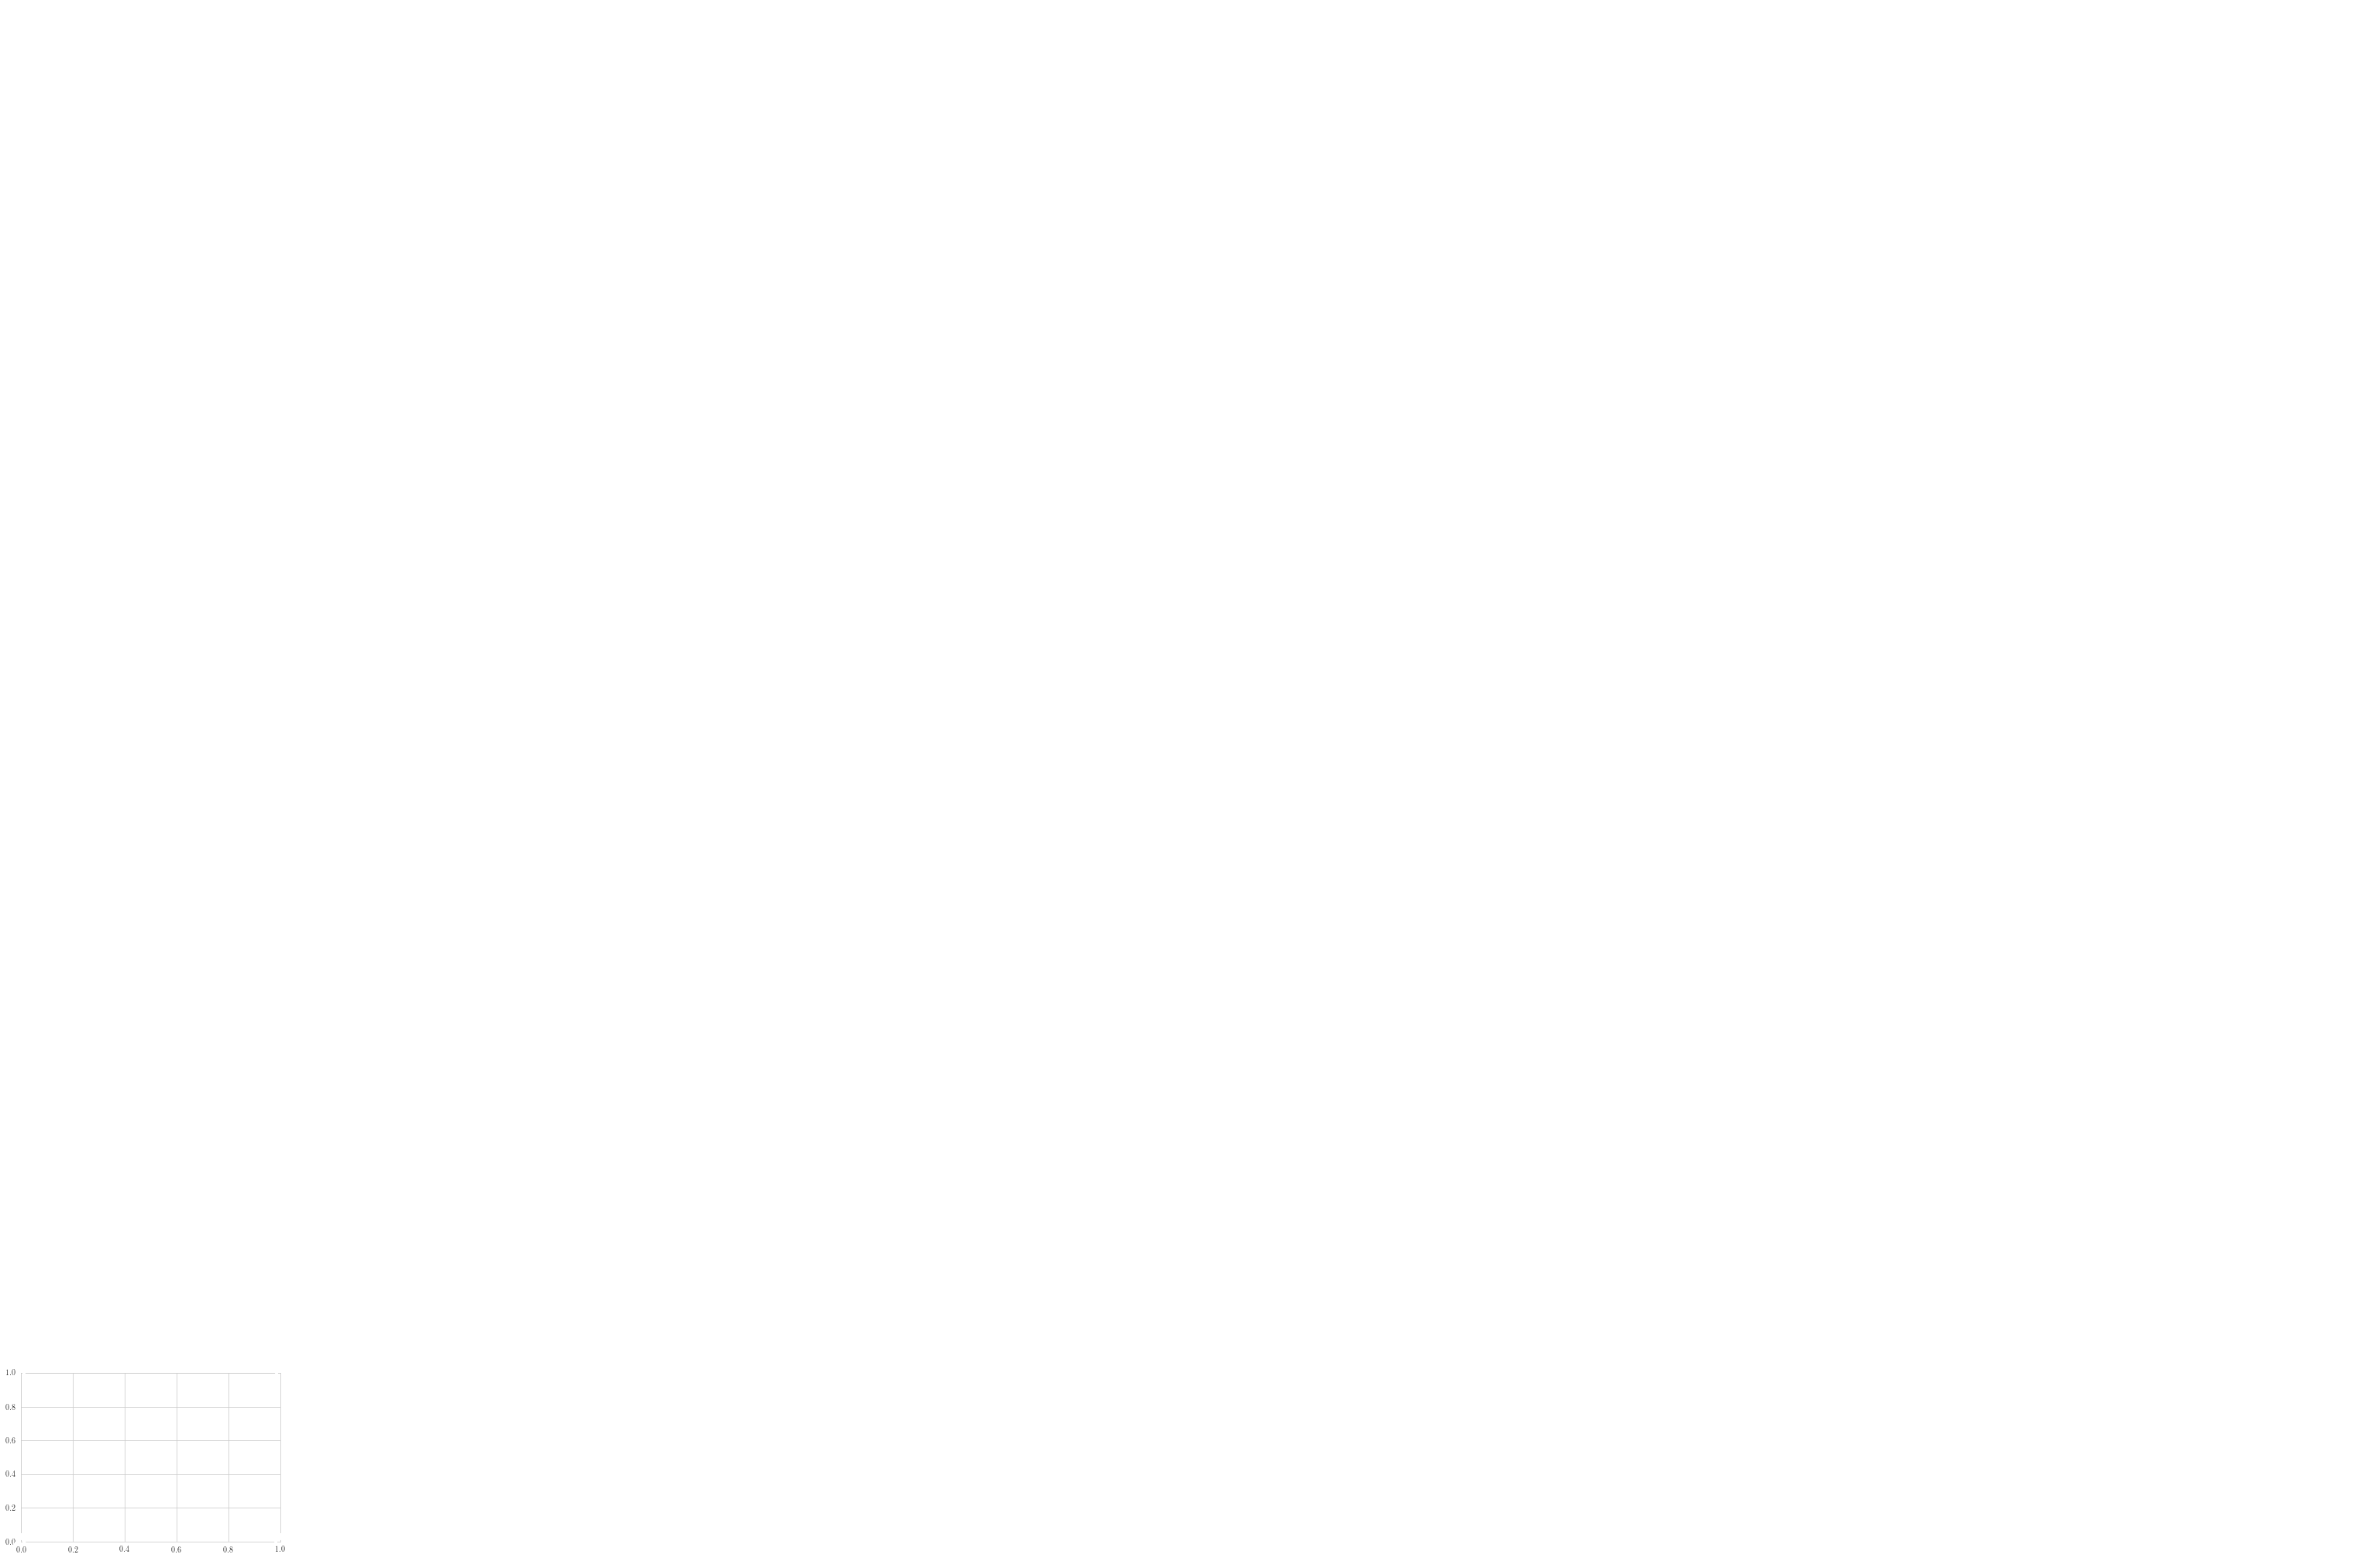

In [174]:
plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=False)

In [148]:
def evaluate_policy(agent, episodes=5, eps=1.0, n_rows=10, n_cols=10, n_win=5):
    env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
    returns = []
    for e in range(episodes):
        done = False
        state = env.reset()
        if state is None:
            state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
        total_reward = 0.
        action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
        state, reward, done, _ = env.step(action)
        actions = env.getEmptySpaces()
        other_action = actions[pi2.getAction(state[0], actions.shape[0], env)]
        state, reward, done, _ = env.step(other_action)
        state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
        total_reward += reward
        
        
        while not done:
            action, _ = agent.act(state, env, eps)
            state, reward, done, _= env.step(action)
            if not done:
                actions = env.getEmptySpaces()
                other_action = actions[pi2.getAction(state[0], actions.shape[0], env)]
                state, reward, done, _ = env.step(other_action)
            state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
            total_reward += reward
        returns.append(total_reward)
    return returns

### Обучение крестиков при обученной стратегии ноликов

In [150]:
n_rows = 10
n_cols = 10
n_win = 5
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
#dqn = DQN(n_rows=n_rows, n_cols=n_cols, action_size=n_rows * n_cols, seed=0)
n_episodes=10000
max_t=1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    if state is None:
        state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
    action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(action)
    actions = env.getEmptySpaces()
    other_action = actions[pi2.getAction(state[0], actions.shape[0], env)]
    state, reward, done, _ = env.step(other_action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    for t in range(max_t):
        action, _ = dqn.act(state, env, eps)
        next_state, reward, done, _ = env.step(action)
        if not done:
            actions = env.getEmptySpaces()
            other_action = actions[pi2.getAction(next_state[0], actions.shape[0], env)]
            next_state, reward, done, _ = env.step(other_action)
        next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
        dqn.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break 
    state = env.reset()
    if state is None:
        state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
    score = 0
    action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(action)
    actions = env.getEmptySpaces()
    other_action = actions[pi2.getAction(state[0], actions.shape[0], env)]
    state, reward, done, _ = env.step(other_action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    for t in range(max_t):
        action, _ = dqn.act(state, env, eps)
        next_state, reward, done, _ = env.step(action)
        if not done:
            actions = env.getEmptySpaces()
            other_action = actions[pi2.getAction(next_state[0], actions.shape[0], env)]
            next_state, reward, done, _ = env.step(other_action)
        next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if i_episode % 100 == 0:
        rewards = evaluate_policy(dqn, episodes=100, eps=eps, n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        print(f"Step: {i_episode+1}, Reward mean: {np.mean(rewards)}, Reward std: {np.std(rewards)}")
        #dqn.save()
        #if np.mean(rewards) > 0.99:
        #    break
    eps = max(eps_end, eps_decay*eps) # decrease epsilon

/tmp/ipykernel_2327/23153129.py:82: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_expected, q_targets)


Episode 100	Average Score: -0.94
Step: 101, Reward mean: -0.94, Reward std: 0.3411744421846396
Episode 200	Average Score: -0.92
Step: 201, Reward mean: -0.98, Reward std: 0.19899748742132398
Episode 300	Average Score: -0.82
Step: 301, Reward mean: -0.88, Reward std: 0.47497368348151664
Episode 400	Average Score: -0.82
Step: 401, Reward mean: -0.96, Reward std: 0.27999999999999997
Episode 500	Average Score: -0.96
Step: 501, Reward mean: -1.0, Reward std: 0.0
Episode 600	Average Score: -0.98
Step: 601, Reward mean: -0.92, Reward std: 0.39191835884530846
Episode 700	Average Score: -0.42
Step: 701, Reward mean: -0.9, Reward std: 0.43588989435406733
Episode 800	Average Score: -0.78
Step: 801, Reward mean: -0.98, Reward std: 0.19899748742132398
Episode 900	Average Score: -0.82
Step: 901, Reward mean: -0.92, Reward std: 0.39191835884530857
Episode 1000	Average Score: -0.88
Step: 1001, Reward mean: -1.0, Reward std: 0.0
Episode 1100	Average Score: -0.60
Step: 1101, Reward mean: -1.0, Reward st

Episode 10000	Average Score: 1.00
Step: 10001, Reward mean: 1.0, Reward std: 0.0


In [151]:
pi1 = DQNStrategy(dqn)

In [152]:
test_games(env, pi1, pi2, n_games=100)

X 1.0 O 0.0


-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   | x |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------

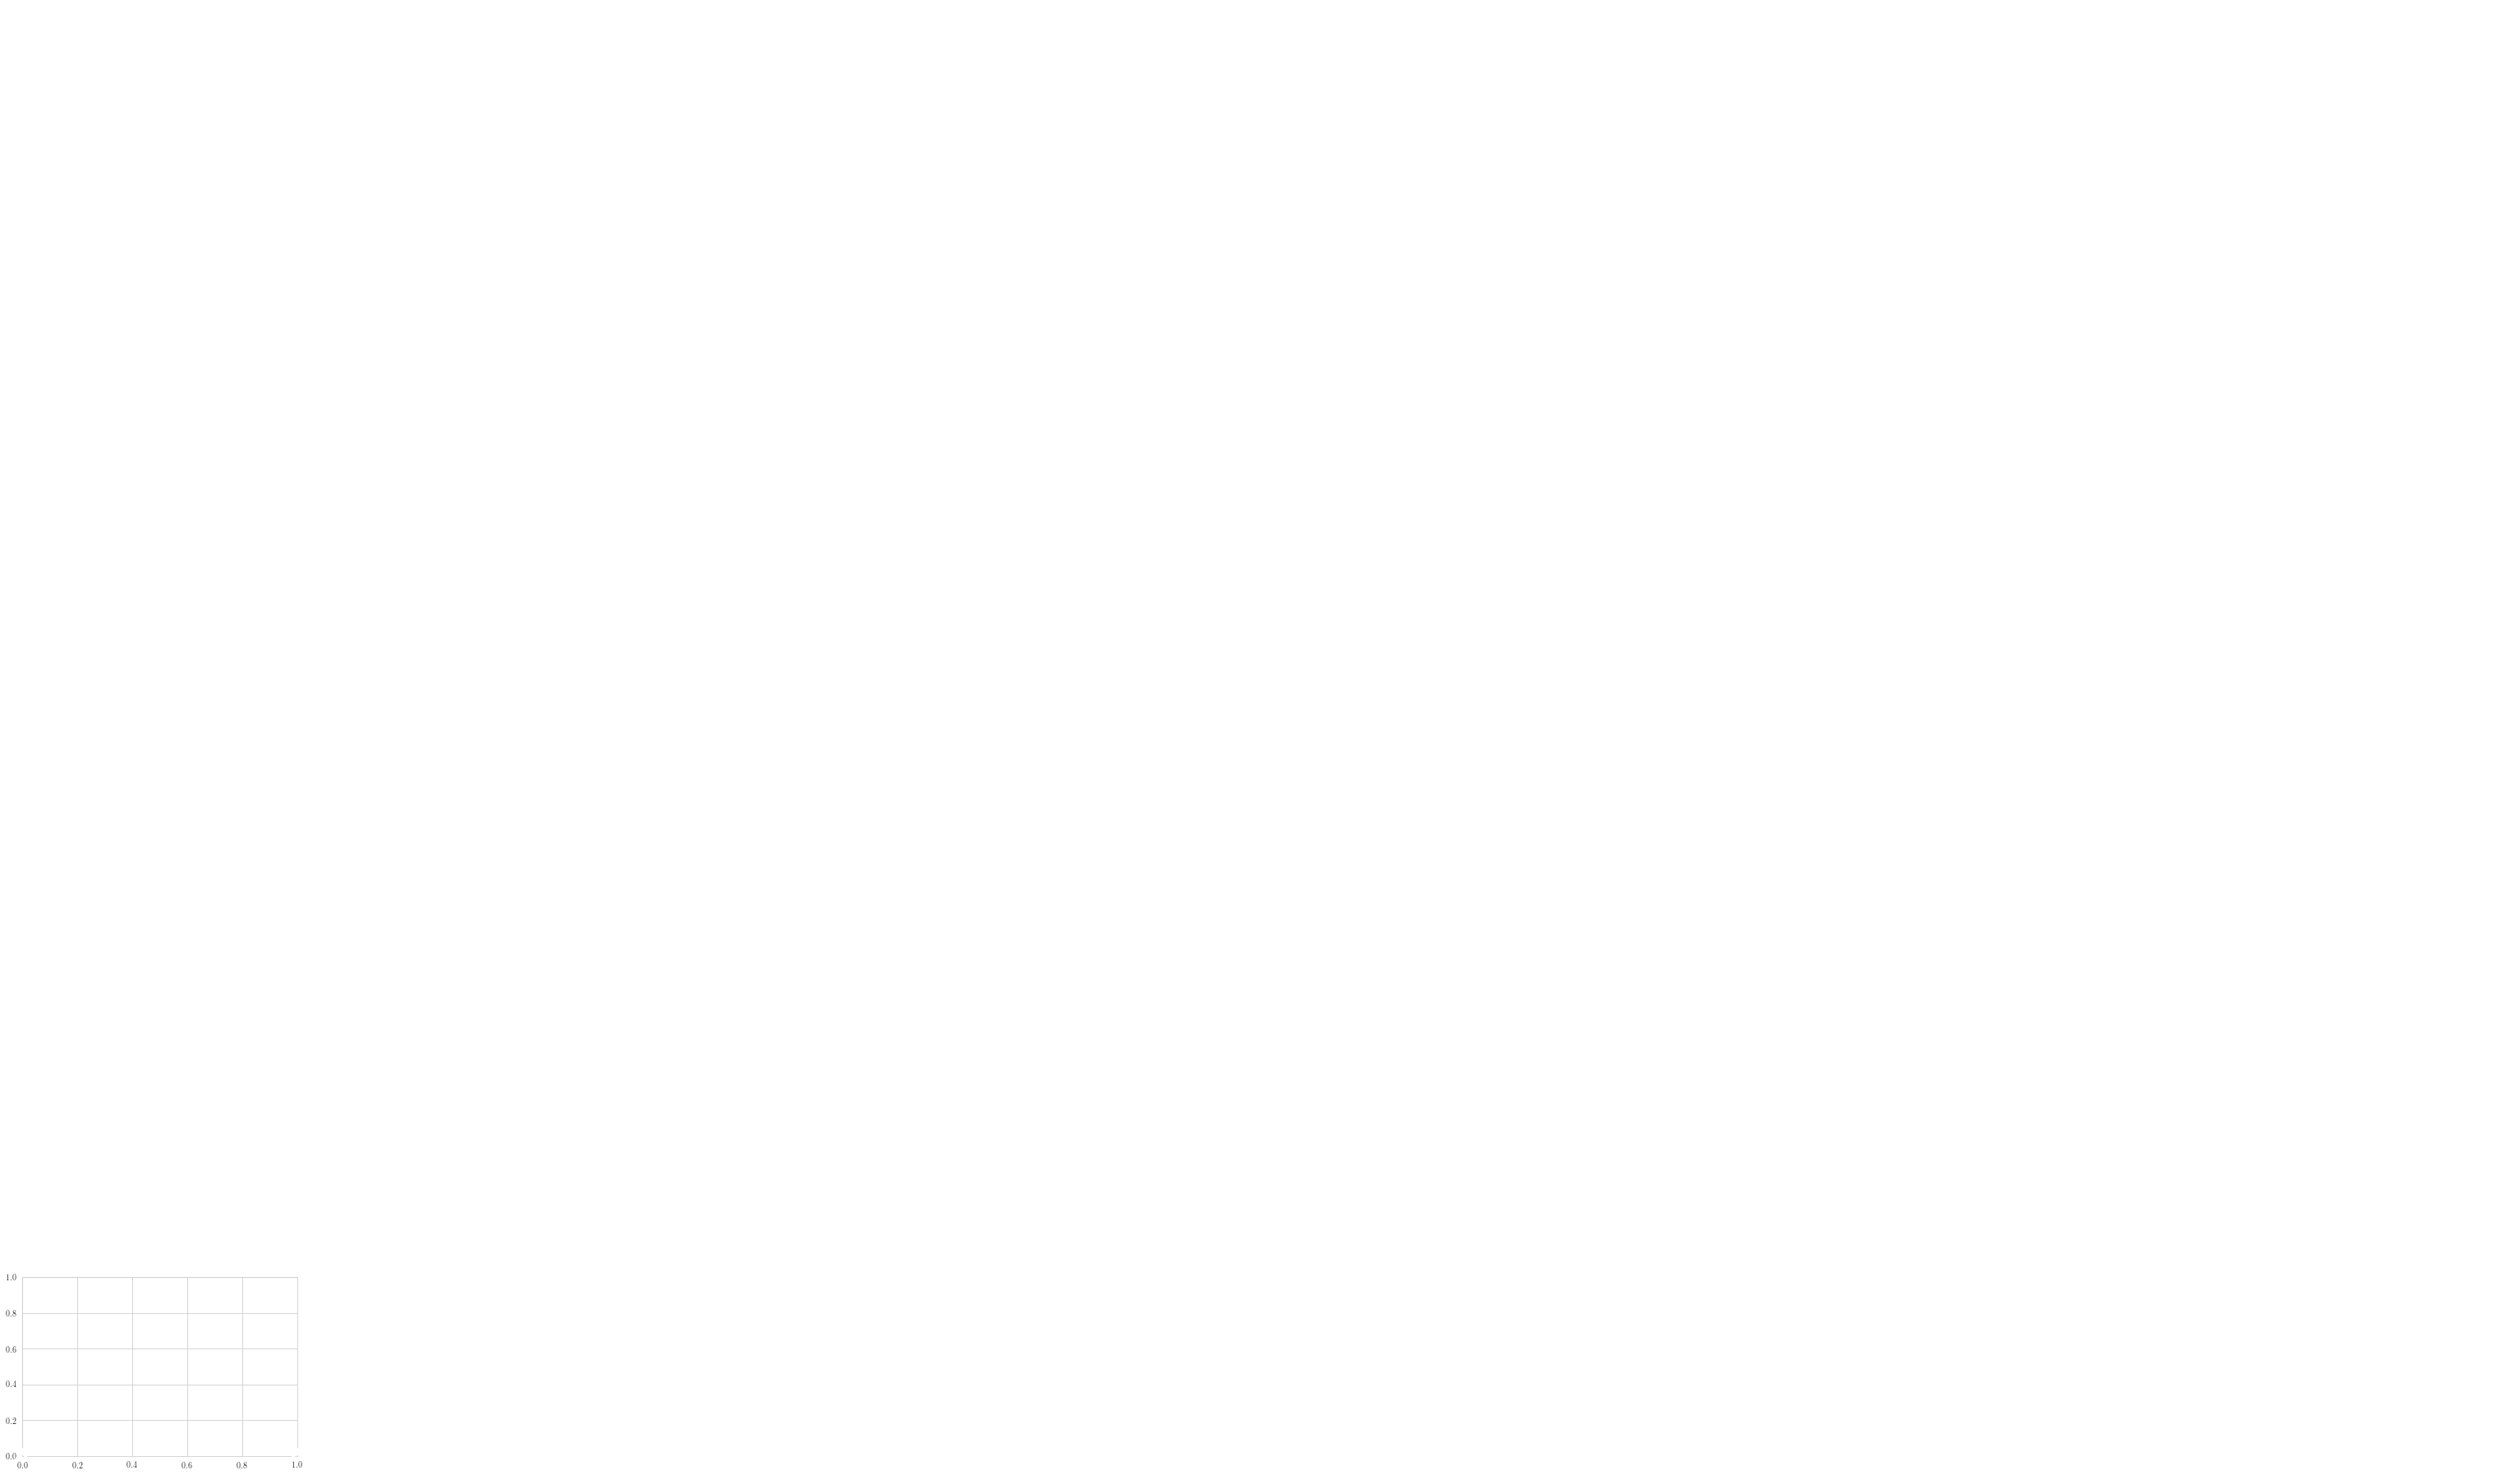

In [154]:
plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=False)

In [175]:
def evaluate_policy_crosses(agent, pi2, episodes=5, eps=1.0, n_rows=10, n_cols=10, n_win=5):
    env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
    returns = []
    for e in range(episodes):
        done = False
        state = env.reset()
        if state is None:
            state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
        total_reward = 0.
        action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
        state, reward, done, _ = env.step(action)
        actions = env.getEmptySpaces()
        other_action = actions[pi2.getAction(state[0], actions.shape[0], env)]
        state, reward, done, _ = env.step(other_action)
        state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
        total_reward += reward
        
        
        while not done:
            action, _ = agent.act(state, env, eps)
            state, reward, done, _= env.step(action)
            if not done:
                actions = env.getEmptySpaces()
                other_action = actions[pi2.getAction(state[0], actions.shape[0], env)]
                state, reward, done, _ = env.step(other_action)
            state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
            total_reward += reward
        returns.append(total_reward)
    return returns

def evaluate_policy_naughts(agent, pi1, episodes=5, eps=1.0, n_rows=10, n_cols=10, n_win=5):
    env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
    returns = []
    for e in range(episodes):
        done = False
        state = env.reset()
        if state is None:
            state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
        total_reward = 0.
        action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
        state, reward, done, _ = env.step(action)
        state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
        
        while not done:
            action, _ = agent.act(state, env, eps)
            state, reward, done, _= env.step(action)
            if not done:
                actions = env.getEmptySpaces()
                other_action = actions[pi1.getAction(state[0], actions.shape[0], env)]
                state, reward, done, _ = env.step(other_action)
            state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
            total_reward -= reward
        returns.append(total_reward)
    return returns

### Одновременное обучение крестиков и ноликов

In [176]:
n_rows = 10
n_cols = 10
n_win = 5
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
#dqn = DQN(n_rows=n_rows, n_cols=n_cols, action_size=n_rows * n_cols, seed=0)
n_episodes=1000
max_t=1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995
scores_crosses = []                        # list containing scores from each episode
scores_naughts = []
scores_window_crosses = deque(maxlen=100)  # last 100 scores
scores_window_naughts = deque(maxlen=100)
eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    if state is None:
        state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
    prev_state = state
    action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    prev_action = action
    state, reward, done, _ = env.step(action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    order = -1
    for t in range(max_t):
        if order == -1:
            action, _ = dqn2.act(state, env, eps)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
            dqn.step(prev_state, prev_action, reward, next_state, done)
        else:
            action, _ = dqn.act(state, env, eps)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
            dqn2.step(prev_state, prev_action, reward, next_state, done)
        prev_action = action
        prev_state = state
        state = next_state
        if done:
            if order == -1:
                dqn2.step(state, action, reward, next_state, done)
            else:
                dqn.step(state, action, reward, next_state, done)
            break
        order = -order
    state = env.reset()
    if state is None:
        state = np.array([1] * n_rows * n_cols).reshape(n_cols, n_rows)
    score_crosses = 0
    score_naughts = 0
    action = env.getEmptySpaces()[np.random.choice(env.getEmptySpaces().shape[0])]
    state, reward, done, _ = env.step(action)
    state = np.array([int(e) for e in state[0]]).reshape(n_cols, n_rows)
    order = -1
    for t in range(max_t):
        if order == -1:
            action, _ = dqn2.act(state, env, eps)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
            score_crosses += reward
        else:
            action, _ = dqn.act(state, env, eps)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array([int(e) for e in next_state[0]]).reshape(n_cols, n_rows)
            score_naughts -= reward
        prev_action = action
        prev_state = state
        state = next_state
        if done:
            if order == -1:
                score_naughts -= reward
            else:
                score_crosses += reward
            break 
    scores_window_crosses.append(score_crosses)       # save most recent score
    scores_window_naughts.append(score_naughts)
    scores_crosses.append(score_crosses)              # save most recent score
    scores_naughts.append(score_naughts)
    
    print('\rEpisode {}\tAverage Score Crosses: {:.2f}\tAverage Score Naughts: {:.2f}'.format(i_episode, np.mean(scores_window_crosses), np.mean(scores_window_naughts)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score Crosses: {:.2f}\tAverage Score Naughts: {:.2f}'.format(i_episode, np.mean(scores_window_crosses), np.mean(scores_window_naughts)))
    if i_episode % 100 == 0:
        pi1 = DQNStrategy(dqn)
        pi2 = DQNStrategy(dqn2)
        rewards = evaluate_policy_crosses(dqn, pi2, episodes=100, eps=eps, n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        print(f"Step: {i_episode+1}, Reward mean: {np.mean(rewards)}, Reward std: {np.std(rewards)}")
        rewards = evaluate_policy_naughts(dqn2, pi1, episodes=100, eps=eps, n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        print(f"Step: {i_episode+1}, Reward mean: {np.mean(rewards)}, Reward std: {np.std(rewards)}")
        #dqn.save()
        #if np.mean(rewards) > 0.99:
        #    break
    eps = max(eps_end, eps_decay*eps) # decrease epsilon

/tmp/ipykernel_2327/23153129.py:82: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_expected, q_targets)


Episode 100	Average Score Crosses: 0.14	Average Score Naughts: -0.14
Step: 101, Reward mean: -1.0, Reward std: 0.0
Step: 101, Reward mean: -0.8, Reward std: 0.6
Episode 200	Average Score Crosses: 0.20	Average Score Naughts: -0.20
Step: 201, Reward mean: -1.0, Reward std: 0.0
Step: 201, Reward mean: 0.42, Reward std: 0.9075241043630742
Episode 300	Average Score Crosses: 0.16	Average Score Naughts: -0.16
Step: 301, Reward mean: -0.86, Reward std: 0.5102940328869229
Step: 301, Reward mean: 0.18, Reward std: 0.983666610188635
Episode 400	Average Score Crosses: 0.17	Average Score Naughts: -0.17
Step: 401, Reward mean: -1.0, Reward std: 0.0
Step: 401, Reward mean: 0.88, Reward std: 0.4749736834815167
Episode 500	Average Score Crosses: 0.12	Average Score Naughts: -0.12
Step: 501, Reward mean: -1.0, Reward std: 0.0
Step: 501, Reward mean: 1.0, Reward std: 0.0
Episode 600	Average Score Crosses: 0.26	Average Score Naughts: -0.26
Step: 601, Reward mean: -0.76, Reward std: 0.6499230723708768
Step:

In [177]:
pi1 = DQNStrategy(dqn)
pi2 = DQNStrategy(dqn2)

In [178]:
test_games(env, pi1, pi2, n_games=100)

X 0.04 O 0.96


-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   | x |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
-----------------------------------------
| o |   |   |   |   |   |   |   |   |   | 
-----------------------

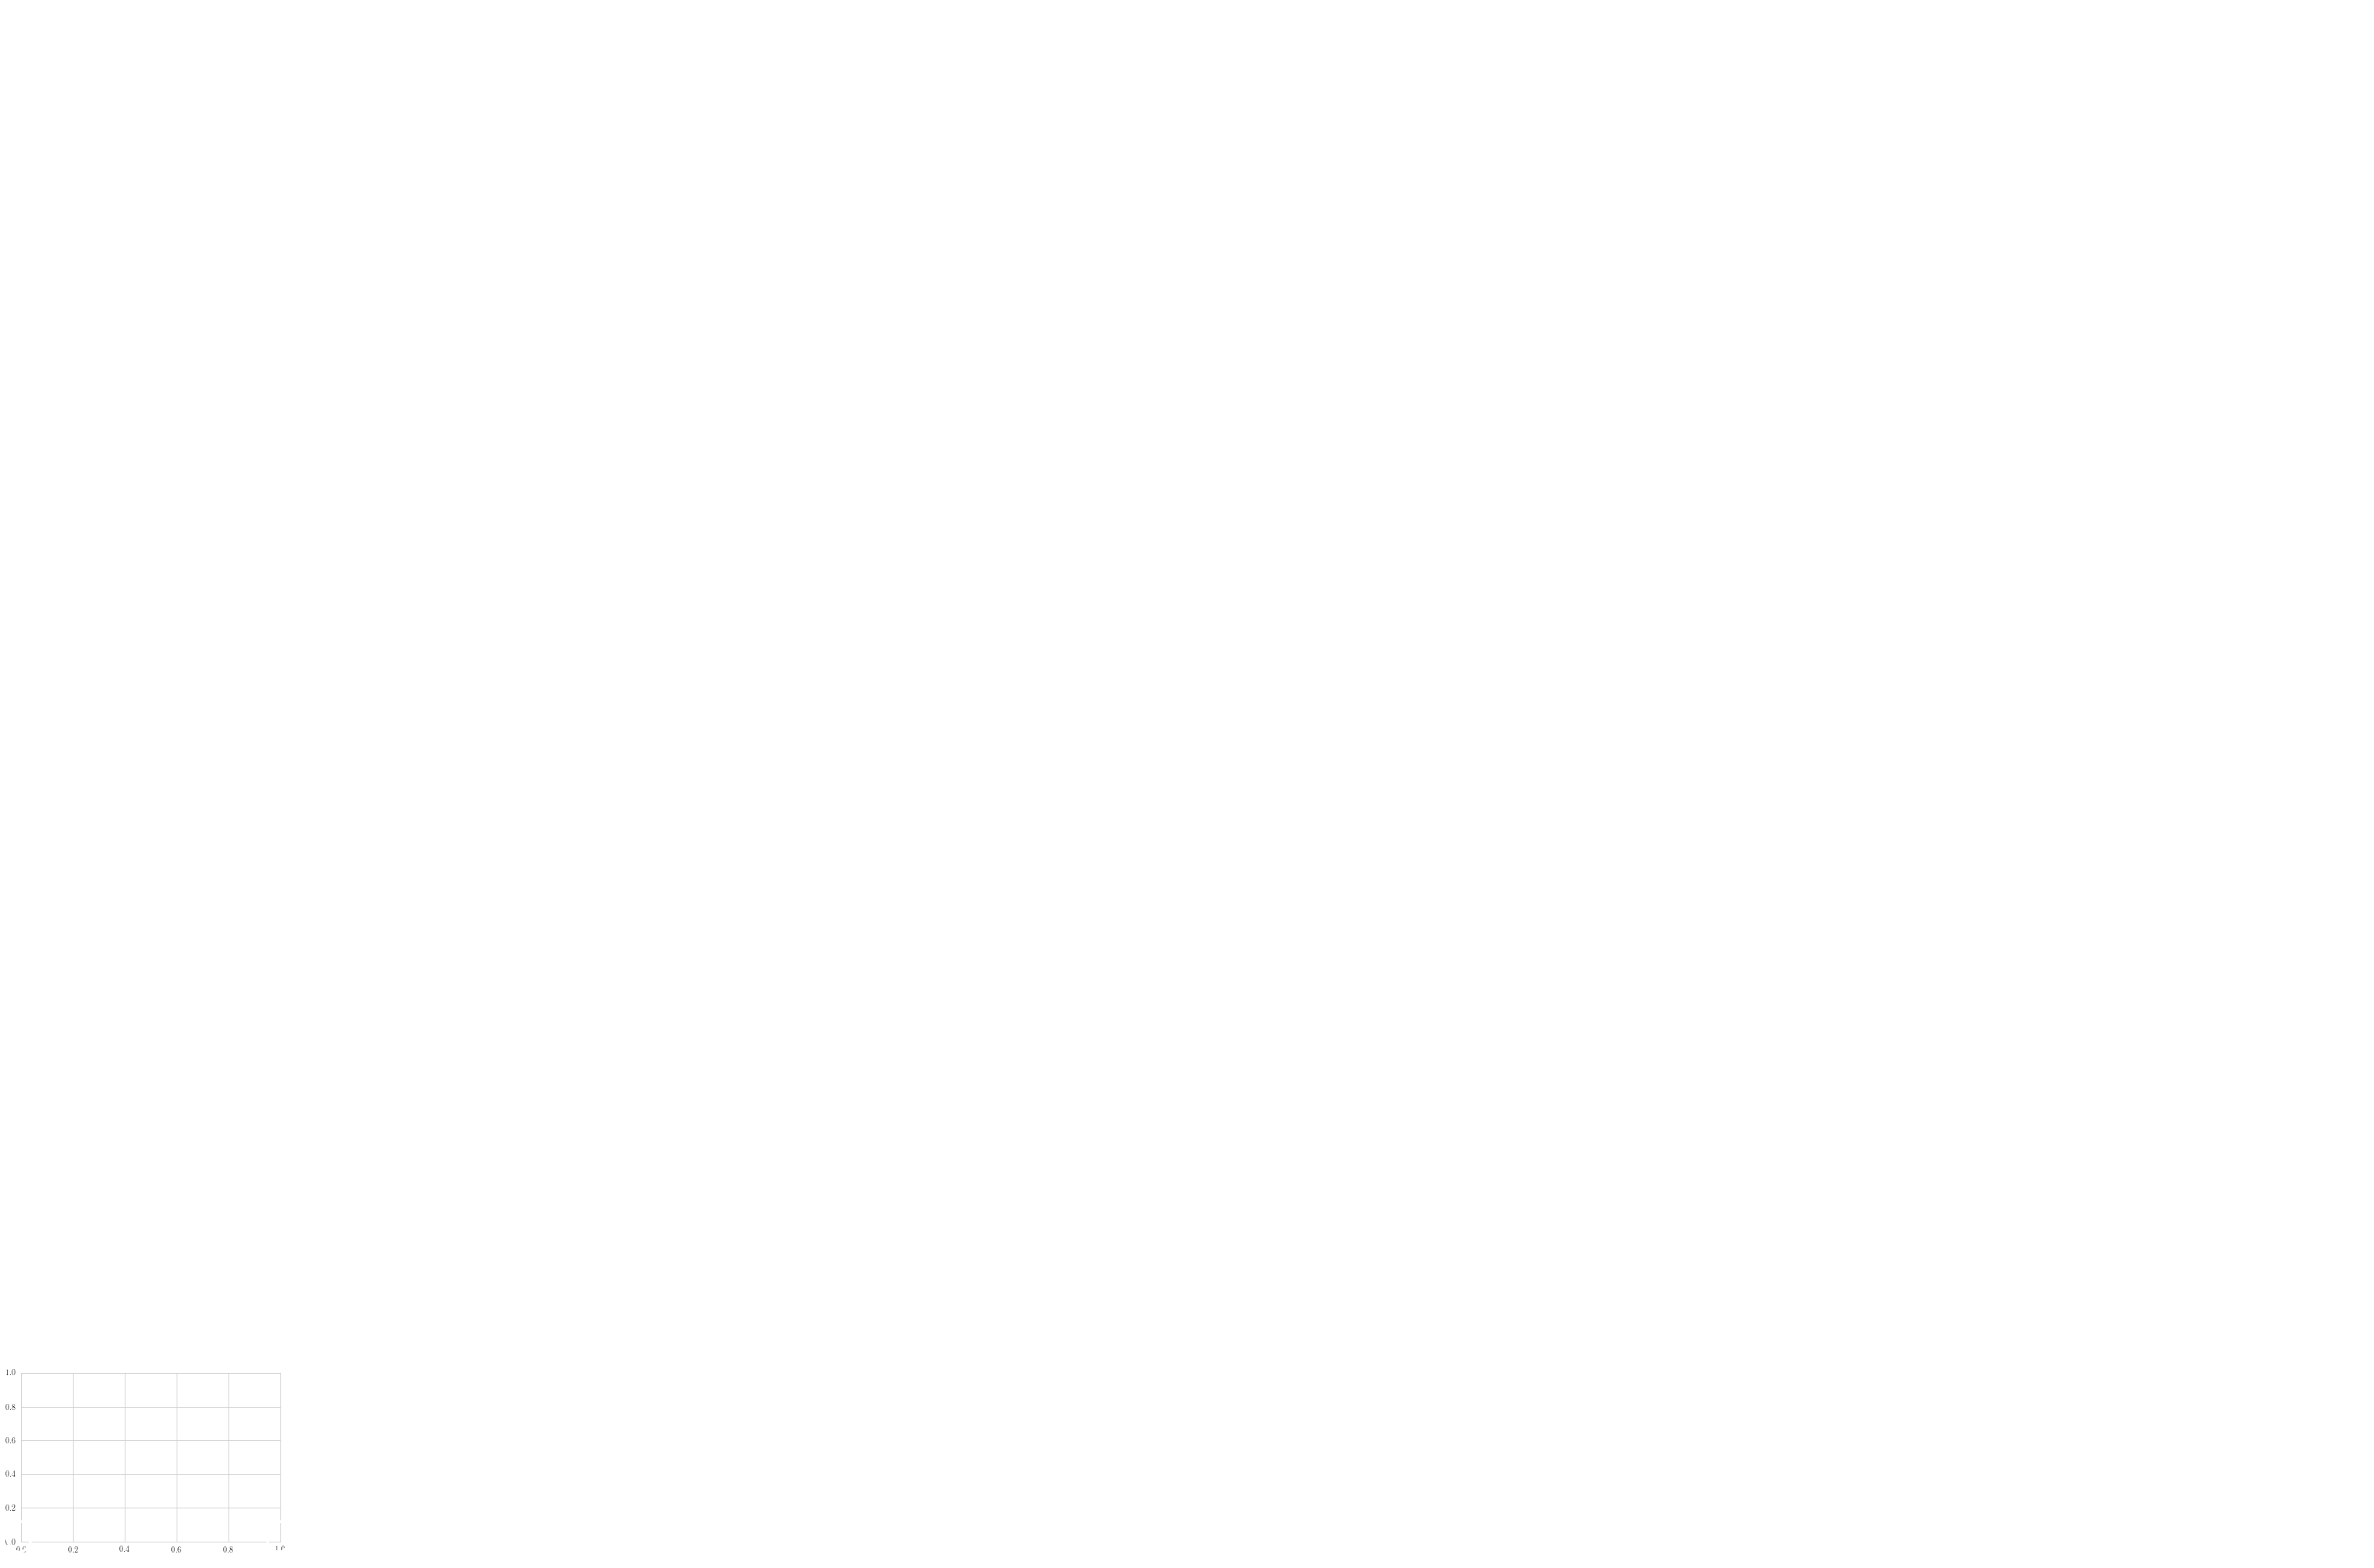

In [181]:
plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=False)

## MCTS

In [8]:
from abc import ABC, abstractmethod
from collections import defaultdict, namedtuple
import math
from random import choice

In [87]:
N_COLS = 10
N_ROWS = 10
N_WIN = 5

In [88]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        invert_reward = True
        while True:
            if node.is_terminal():
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return 0

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True

### Нолики против рандомной стратегии крестиков

In [93]:
_TTTB = namedtuple("TicTacToeBoard", "tup turn winner terminal")

# Inheriting from a namedtuple is convenient because it makes the class
# immutable and predefines __init__, __repr__, __hash__, __eq__, and others
class TicTacToeBoard(_TTTB, Node):
    def find_children(board):
        if board.terminal:  # If the game is finished then no moves can be made
            return set()
        # Otherwise, you can make a move in each of the empty spots
        return {
            board.make_move(i) for i, value in enumerate(board.tup) if value is None
        }

    def find_random_child(board):
        if board.terminal:
            return None  # If the game is finished then no moves can be made
        empty_spots = [i for i, value in enumerate(board.tup) if value is None]
        return board.make_move(choice(empty_spots))

    def reward(board):
        if not board.terminal:
            raise RuntimeError(f"reward called on nonterminal board {board}")
        if board.winner is board.turn:
            # It's your turn and you've already won. Should be impossible.
            raise RuntimeError(f"reward called on unreachable board {board}")
        if board.turn is (not board.winner):
            return 0  # Your opponent has just won. Bad.
        if board.winner is None:
            return 0.5  # Board is a tie
        # The winner is neither True, False, nor None
        raise RuntimeError(f"board has unknown winner type {board.winner}")

    def is_terminal(board):
        return board.terminal

    def make_move(board, index):
        tup = board.tup[:index] + (board.turn,) + board.tup[index + 1 :]
        turn = not board.turn
        winner = _find_winner(tup, index)
        is_terminal = (winner is not None) or not any(v is None for v in tup)
        return TicTacToeBoard(tup, turn, winner, is_terminal)

    def to_pretty_string(board):
        to_char = lambda v: ("X" if v is True else ("O" if v is False else " "))
        rows = [
            [to_char(board.tup[N_COLS * row + col]) for col in range(N_COLS)] for row in range(N_ROWS)
        ]
        res = " ".join([str(i + 1) for i in range(N_COLS)])
        return (
            "\n  " + res + "\n"
            + "\n".join(str(i + 1) + " " + " ".join(row) for i, row in enumerate(rows))
            + "\n"
        )


def play_game(random=True):
    tree = MCTS()
    board = new_tic_tac_toe_board()
    print(board.to_pretty_string())
    while True:
        if not random:
            row_col = input("enter row,col: ")
            row, col = map(int, row_col.split(","))
            index = N_COLS * (row - 1) + (col - 1)
        else:
            empty_spots = [i for i, value in enumerate(board.tup) if value is None]
            index = choice(empty_spots)
        if board.tup[index] is not None:
            raise RuntimeError("Invalid move")
        board = board.make_move(index)
        print(board.to_pretty_string())
        if board.terminal:
            break
        # You can train as you go, or only at the beginning.
        # Here, we train as we go, doing fifty rollouts each turn.
        for _ in range(50):
            tree.do_rollout(board)
        board = tree.choose(board)
        print(board.to_pretty_string())
        if board.terminal:
            break
            
def test_games(n_games=100):
    cross_wins = 0
    naught_wins = 0
    for _ in range(n_games):
        tree = MCTS()
        board = new_tic_tac_toe_board()
        while True:
            empty_spots = [i for i, value in enumerate(board.tup) if value is None]
            index = choice(empty_spots)
            if board.tup[index] is not None:
                raise RuntimeError("Invalid move")
            board = board.make_move(index)
            if board.terminal:
                cross_wins += 1
                break
            # You can train as you go, or only at the beginning.
            # Here, we train as we go, doing fifty rollouts each turn.
            for _ in range(250):
                tree.do_rollout(board)
            board = tree.choose(board)
            if board.terminal:
                naught_wins += 1
                break
    print(f'X {cross_wins / n_games} O {naught_wins / n_games}')

def _find_winner(tup, idx):
    field = np.array(tup).reshape(N_COLS, N_ROWS)
    idx_col = idx % N_COLS
    idx_row = math.ceil((idx + 1) / N_COLS) - 1
    cur = tup[idx]
    c = 1
    i = idx_row - 1
    while i >= 0 and idx_row - i < N_WIN - 1 and field[i, idx_col] == cur:
        i -= 1
        c += 1
    i = idx_row + 1
    while i < N_ROWS and i - idx_row < N_WIN - 1 and field[i, idx_col] == cur:
        i += 1
        c += 1
    if c >= N_WIN:
        return cur
    
    c = 1
    i = idx_col - 1
    while i >= 0 and idx_col - i <= N_WIN - 1 and field[idx_row, i] == cur:
        i -= 1
        c += 1
    i = idx_col + 1
    while i < N_COLS and i - idx_col <= N_WIN - 1 and field[idx_row, i] == cur:
        i += 1
        c += 1
    if c >= N_WIN:
        return cur
    
    c = 1
    i = idx_col - 1
    j = idx_row - 1
    while i >= 0 and j >= 0 and idx_col - i <= N_WIN - 1 and field[j, i] == cur:
        i -= 1
        j -= 1
        c += 1
    i = idx_col + 1
    j = idx_row + 1
    while i < N_COLS and j < N_ROWS and i - idx_col <= N_WIN - 1 and field[j, i] == cur:
        i += 1
        j += 1
        c += 1
    if c >= N_WIN:
        return cur
    
    c = 1
    i = idx_col - 1
    j = idx_row + 1
    while i >= 0 and j < N_ROWS and idx_col - i <= N_WIN - 1 and field[j, i] == cur:
        i -= 1
        j += 1
        c += 1
    i = idx_col + 1
    j = idx_row - 1
    while i < N_COLS and j >= 0 and i - idx_col <= N_WIN - 1 and field[j, i] == cur:
        i += 1
        j -= 1
        c += 1
    if c >= N_WIN:
        return cur
    return None


def new_tic_tac_toe_board():
    return TicTacToeBoard(tup=(None,) * N_COLS * N_ROWS, turn=True, winner=None, terminal=False)

Среднее число побед крестиков и ноликов при рандомной стратегии крестиков усредненное по 25 играм

In [94]:
test_games(n_games=25)

X 0.04 O 0.96
